<a href="https://colab.research.google.com/github/calliopz/MachineLearning/blob/master/Text_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# instalar libs
!pip install livelossplot

In [0]:
#origem: https://github.com/tensorflow/workshops/blob/master/extras/keras-bag-of-words/keras-bow-model.ipynb
#importar bibliotecas


import logging
import pandas as pd
import numpy as np
from numpy import random
import gensim
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import re
from bs4 import BeautifulSoup
from sklearn.linear_model import SGDClassifier

from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import classification_report



# Início do Machine Learning com Karas abaixo

import itertools
import os

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.preprocessing import text, sequence
from keras import utils, optimizers

from livelossplot.keras import PlotLossesCallback


%matplotlib inline

#info sobre o TensorFlow

print("TensorFlow version", tf.__version__)

print("Using GPU?", tf.test.is_gpu_available(
    cuda_only=False,
    min_cuda_compute_capability=None
), tf.test.gpu_device_name()
)





Using TensorFlow backend.


TensorFlow version 1.13.1
Using GPU? True /device:GPU:0


In [0]:
from google.colab import drive
drive.mount('/content/gdrive')



Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# faz leitura do CSV 
file = '/content/gdrive/My Drive/Machine Learning/NLP/stack-overflow-data.csv'

df = pd.read_csv(file)
df = df[pd.notnull(df['tags'])]

#Embaralhar o DataFrame

df = df.sample(frac=1).reset_index(drop=True)

# Alternativa para emabaralhar o df
#from sklearn.utils import shuffle
#df = shuffle(df)


#Exibir amostra o DataFrame

df.head(10)

,post,tags
0,how do i display html code (entities) on a web...,html
1,uiwebview does not load full content from an u...,ios
2,how do i make a program with multiple classes ...,java
3,how to read doubles from a .txt file i m able...,java
4,rand() and srand() functions in c++ i have be...,c++
5,filtering one list based on another list c# i...,c#
6,using jquery to get a shortened url establishe...,jquery
7,troubles with query i ve got table <code>tcon...,sql
8,file upload control issues in i.e i am having...,.net
9,c# bestpractice: writing a method that returns...,c#


In [0]:
# Calcula a quantidade de palavras na base de dados
print ('Quantidade de palavras totais:')
df['post'].apply(lambda x: len(x.split(' '))).sum()

Quantidade de palavras totais:


10286120

In [0]:
#descobre e cria uma lista de quais são as categorias possíveis na coluna 'tags'

my_tags = list(set(df['tags']))
print (my_tags)
print(len(my_tags))

['html', 'asp.net', 'javascript', 'php', 'mysql', 'jquery', 'iphone', 'ruby-on-rails', 'python', 'android', 'java', 'sql', 'objective-c', 'css', 'angularjs', 'ios', 'c#', '.net', 'c++', 'c']
20


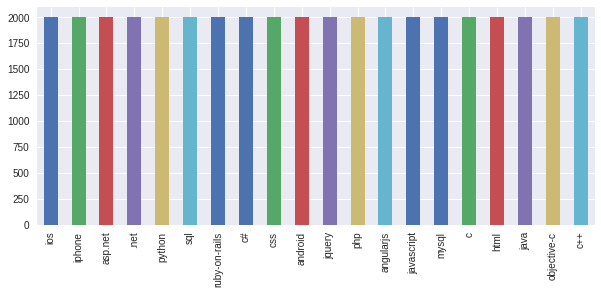

In [0]:
# Cria um gráfico comparando a distribuição das observações das tags

plt.figure(figsize=(10,4))
df.tags.value_counts().plot(kind='bar');

# Limpeza do texto

In [0]:
# Verificando como está o texto na coluna "post"
def print_plot(index):
    example = df[df.index == index][['post', 'tags']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Tag:', example[1])

print('Antes a limpeza:')

print_plot(10)

Antes a limpeza:
request.browser.ismobiledevice works on one server but not another   i am using the command request.browser.ismobiledevice to load a mobile site js and html  it works great locally and on our dev server  but not on our staging server.    the .net and iis version is the exact same  is there anything else that controls this command    thanks
Tag: asp.net


In [0]:
# Limpeza do texto coluna "post"

import nltk
nltk.download('stopwords')

REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))


def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = BeautifulSoup(text, "lxml").text # HTML decoding
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
    return text

df['post'] = df['post'].apply(clean_text)


print('Após a limpeza:')
print_plot(10)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
Após a limpeza:
requestbrowserismobiledevice works one server another using command requestbrowserismobiledevice load mobile site js html works great locally dev server staging server net iis version exact anything else controls command thanks
Tag: asp.net


In [0]:
print ('Quantidade de palavras após a limpeza:')

df['post'].apply(lambda x: len(x.split(' '))).sum()

Quantidade de palavras após a limpeza:


3424297

# Início do Machine Learning

In [0]:
print ('Quantidade de observações a serem trabalhadas:')
len(df)

Quantidade de observações a serem trabalhadas:


40000

In [0]:
train_size = int(len(df) * .7)
print ("Train size: %d" % train_size)
print ("Test size: %d" % (len(df) - train_size))

Train size: 28000
Test size: 12000


In [0]:
train_posts = df['post'][:train_size]
train_tags = df['tags'][:train_size]

test_posts = df['post'][train_size:]
test_tags = df['tags'][train_size:]

In [0]:
max_words = 1000
tokenize = text.Tokenizer(num_words=max_words, char_level=False)

In [0]:
tokenize.fit_on_texts(train_posts) # only fit on train
x_train = tokenize.texts_to_matrix(train_posts)
x_test = tokenize.texts_to_matrix(test_posts)

In [0]:
print(
    x_test)

[[0. 1. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 1. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [0]:
encoder = LabelEncoder()
encoder.fit(my_tags)
y_train = encoder.transform(train_tags)
y_test = encoder.transform(test_tags)

In [0]:
num_classes = np.max(y_train) + 1
y_train = utils.to_categorical(y_train, num_classes)
y_test = utils.to_categorical(y_test, num_classes)

In [0]:
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

x_train shape: (28000, 1000)
x_test shape: (12000, 1000)
y_train shape: (28000, 20)
y_test shape: (12000, 20)


In [0]:
# Modelo 1
# Build the model

model = Sequential()
model.add(Dense(256, activation='relu', input_shape=(max_words,)))
model.add(Dropout(0.9))
#model.add(Dense(64, activation='relu'))
#model.add(Dropout(0.5))
#model.add(Dense(32, activation='relu'))
#model.add(Dropout(0.5))
#model.add(Dense(16, activation='relu'))
#model.add(Dropout(0.5))
model.add(Dense((num_classes), activation='softmax'))



keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)


model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
# Parâmetros do treino
batch_size = 32 #@param {type: "slider", min: 32, max: 256, step: 32} 
epochs = 20 #@param {type: "slider", min: 10, max: 200, step: 10} 
validation_split= 0.1 #@param {type: "slider", min: 0.05, max: 1, step: 0.05}

In [0]:
# Parâmetros para Early Stopping

monitor='val_loss' #@param ["val_acc", "val_loss"]
min_delta=0 #@param {type: "slider", min: 0, max: 5, step: 0.1} 
patience=15 #@param {type: "slider", min: 0, max: 50, step: 1} 
verbose=0 #@param {type: "slider", min: 0, max: 1, step: 1} 
mode='auto' #@param ["auto", "min", "max"]
restore_best_weights=True #@param {type:"boolean"}




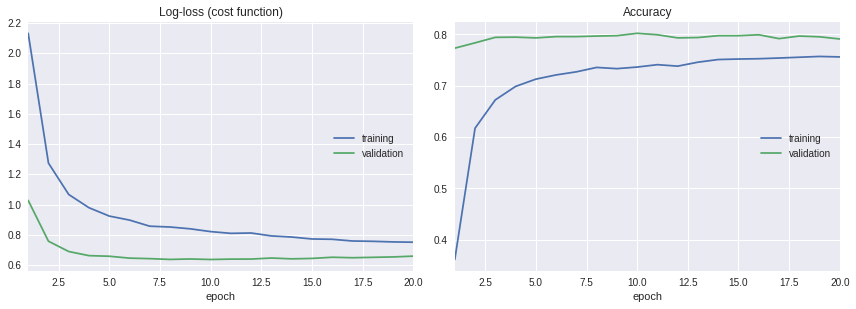

Log-loss (cost function):
training   (min:    0.751, max:    2.132, cur:    0.751)
validation (min:    0.637, max:    1.027, cur:    0.659)

Accuracy:
training   (min:    0.362, max:    0.757, cur:    0.756)
validation (min:    0.773, max:    0.802, cur:    0.791)
12000/12000 [==============================] - 1s 54us/step
Test accuracy: 0.8009166666666667


In [0]:
model.summary()

earlystop = keras.callbacks.EarlyStopping(monitor=monitor, 
                                          min_delta=min_delta, 
                                          patience=patience, 
                                          verbose=verbose, 
                                          mode=mode, 
                                          baseline=None, 
                                          restore_best_weights=restore_best_weights)


history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    callbacks=[PlotLossesCallback(), earlystop],
                    verbose=1,
                    validation_split=validation_split)

score = model.evaluate(x_test, y_test,
                       batch_size=batch_size, verbose=1)
print('Test accuracy:', score[1])

# Linear Support Vector Machine


In [0]:
X = df.post
y = df.tags
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

In [0]:


sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])
sgd.fit(X_train, y_train)

%time

y_pred = sgd.predict(X_test)

my_tags = list(set(y_train))

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_tags))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


CPU times: user 14 µs, sys: 2 µs, total: 16 µs
Wall time: 19.3 µs
accuracy 0.782
               precision    recall  f1-score   support

ruby-on-rails       0.75      0.63      0.69       614
         html       0.84      0.93      0.89       617
      asp.net       0.89      0.96      0.93       608
          php       0.76      0.79      0.78       596
   javascript       0.74      0.90      0.81       591
       jquery       0.79      0.39      0.52       617
       iphone       0.83      0.67      0.74       587
        mysql       0.69      0.93      0.79       602
      android       0.81      0.59      0.68       605
         java       0.76      0.59      0.67       583
          sql       0.72      0.68      0.70       614
  objective-c       0.80      0.82      0.81       605
          css       0.80      0.77      0.78       637
    angularjs       0.79      0.86      0.82       580
         .net       0.84      0.78      0.81       609
          ios       0.68      0.68    

# Salvar modelo em arquivo JSON

In [0]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Modelo salvo em arquivo")

# Carregar modelo do Arquivo

In [0]:
from keras.models import model_from_json

# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Modelo carregado do arquivo")

Modelo carregado do arquivo


In [0]:
# Testar modelo carregado 

loaded_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
score = loaded_model.evaluate(x_test, y_test,
                       batch_size=batch_size, verbose=1)
print('Test accuracy:', score[1])
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

331/331 [==============================] - 6s 17ms/step
Test accuracy: 0.4410876138332747
acc: 44.11%


# Apêndice

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


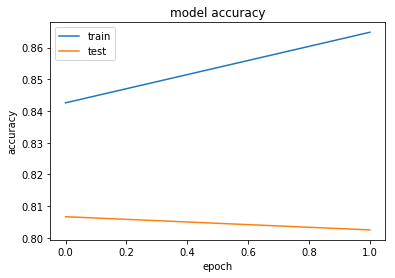

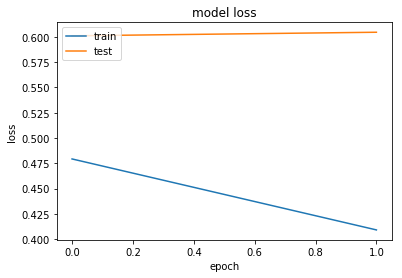

In [0]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
# Here's how to generate a prediction on individual examples
text_labels = encoder.classes_ 

for i in range(10):
    prediction = model.predict(np.array([x_test[i]]))
    predicted_label = text_labels[np.argmax(prediction)]
    print(test_posts.iloc[i][:50], "...")
    print('Actual label:' + test_tags.iloc[i])
    print("Predicted label: " + predicted_label + "\n")

autoplay youtube video hover mouseover trying play ...
Actual label:jquery
Predicted label: jquery

android product anr often occurs anr always interr ...
Actual label:android
Predicted label: android

printing objectivec method implementation runtime  ...
Actual label:objective-c
Predicted label: objective-c

execvp system call executing char args 41 char str ...
Actual label:c
Predicted label: c

html decrease page size way decrease squish size h ...
Actual label:html
Predicted label: html

update join table record primary keys rails join t ...
Actual label:ruby-on-rails
Predicted label: ruby-on-rails

subtraction 1 number 00011 00010 int working simpl ...
Actual label:objective-c
Predicted label: objective-c

jquery function p 0 tried script p 0 innerhtml hi  ...
Actual label:jquery
Predicted label: jquery

error calling calculate function int input functio ...
Actual label:c#
Predicted label: c#

sql condition sql statement like select order orde ...
Actual label:sql
Predicted labe

In [0]:
y_softmax = model.predict(x_test)

y_test_1d = []
y_pred_1d = []

for i in range(len(y_test)):
    probs = y_test[i]
    index_arr = np.nonzero(probs)
    one_hot_index = index_arr[0].item(0)
    y_test_1d.append(one_hot_index)

for i in range(0, len(y_softmax)):
    probs = y_softmax[i]
    predicted_index = np.argmax(probs)
    y_pred_1d.append(predicted_index)

In [0]:
# This utility function is from the sklearn docs: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

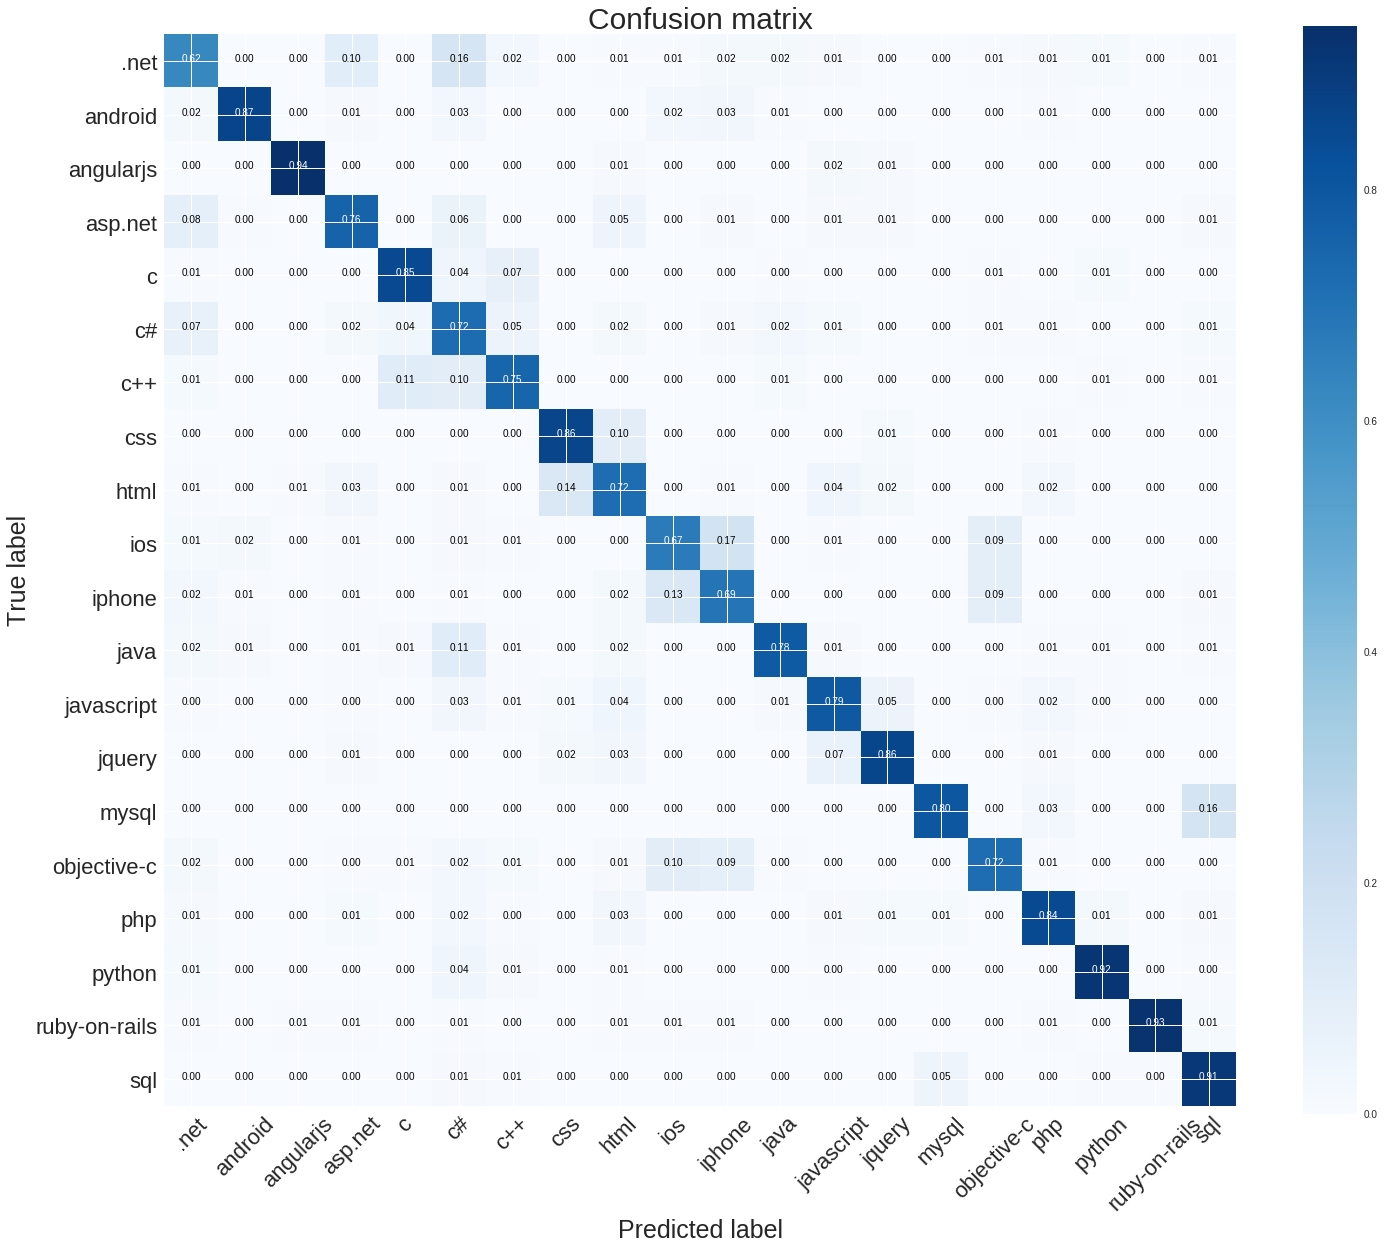

In [0]:
cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(24,20))
plot_confusion_matrix(cnf_matrix, classes=text_labels, title="Confusion matrix")
plt.show()